In [400]:
!pip install emnist #installazione dataset

In [401]:
from google.colab.patches import cv2_imshow
import os
import sys
import gzip
import math

from io import BytesIO
from pathlib import Path
from statistics import mean
from itertools import product, count
from contextlib import redirect_stdout

import cv2
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.cluster import DBSCAN

from emnist import extract_training_samples

from __future__ import print_function
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split


from google.colab.patches import cv2_imshow
import math

In [402]:
def create_complex_model(input_size,output_size): #creazione modello
    model = Sequential()

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (input_size[0], input_size[1], input_size[2])))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [403]:
def creaCartelle():
  if(os.path.isdir("/home/foto")  == False and len("/home/foto")>0):
    os.makedirs("/home/foto")
  if(os.path.isdir("/home/celle")  == False and len("/home/celle")>0):
    os.makedirs("/home/celle")
  if(os.path.isdir("/home/modello")  == False and len("/home/modello")>0):
    os.makedirs("/home/modello")
  if(os.path.isdir("/home/spriteStanza")  == False and len("/home/spriteStanza")>0):
    os.makedirs("/home/spriteStanza")
  if(os.path.isdir("/home/sprite")  == False and len("/home/sprite")>0):
    os.makedirs("/home/sprite")
  if(os.path.isdir("/home/sprite/luigiMovimento")  == False and len("/home/sprite/luigiMovimento")>0):
    os.makedirs("/home/sprite/luigiMovimento")
  if(os.path.isdir("/home/sprite/luigiClean")  == False and len("/home/sprite/luigiClean")>0):
    os.makedirs("/home/sprite/luigiClean")
  if(os.path.isdir("/home/sprite/altri")  == False and len("/home/sprite/altri")>0):
    os.makedirs("/home/sprite/altri")
  if(os.path.isdir("/home/sprite/luigiStart")  == False and len("/home/sprite/luigiStart")>0):
    os.makedirs("/home/sprite/luigiStart")
  if(os.path.isdir("/home/sprite/luigiFinale")  == False and len("/home/sprite/luigiFinale")>0):
    os.makedirs("/home/sprite/luigiFinale")
  
def coppie_adiacenti(seq):
    it = iter(seq)
    first_val = next(it)
    val1 = first_val
    for val2 in it:
        yield val1, val2
        val1 = val2
    yield val1, first_val

def rect_area(rect):
    x, y, w, h = rect
    return h*w

def disegna_linee(image, line, color, thickness=1):
    h, w, *_ = image.shape
    rho, theta = line
    a = math.cos(theta)
    b = math.sin(theta)

    if np.pi/4 <= theta < np.pi*3/4:
        p1 = 0, round(rho/b)
        p2 = w, round((rho - w*a)/b)
    else:
        p1 = round(rho/a), 0
        p2 = round((rho - h*b)/a), h

    return cv2.line(image, p1, p2, color, thickness)

def media_linee(lines):
    lines = np.array(lines)
    for i, (rho, theta) in enumerate(lines):
        if theta > np.pi*3/4:
            lines[i] = -rho, theta-np.pi


    rhos, thetas = lines.T
    scale = abs(min(rhos)-max(rhos))/np.pi
    scaled_lines = np.column_stack((rhos, thetas*scale))
    model = DBSCAN(eps=24, min_samples=1)
    model.fit(scaled_lines)
    clusters = {}
    for label, line in zip(model.labels_, lines):
        clusters.setdefault(label, []).append(line)
    mean_lines = []
    for label, line_cluster in clusters.items():
        mean_lines.append(np.apply_along_axis(mean, 0, np.array(line_cluster)))
    for i, (rho, theta) in enumerate(mean_lines):
        if theta < 0:
            mean_lines[i] = -rho, theta+np.pi
    return mean_lines

def intersezioni_linee(l1, l2):
    rho1, theta1 = l1
    rho2, theta2 = l2
    ct1 = math.cos(theta1)
    st1 = math.sin(theta1)
    ct2 = math.cos(theta2)
    st2 = math.sin(theta2)
    det = ct1*st2 - st1*ct2
    if det:
        return (int((st2*rho1 - st1*rho2)/det),
                int((-ct2*rho1 + ct1*rho2)/det))
    else:
        raise ValueError("l1 and l2 are parallel")

def distanza_punti(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

def distanza_bordo(image, point):
    x, y = point
    h, w, *_ = image.shape
    return min(x, w-x-1, y, h-y-1)

def blob_griglia(image):
    h, w = image.shape
    search_image = cv2.bitwise_and(image, 64)
    best_area = 0
    largest_blob = None
    for y, x in product(range(h), range(w)):
        if not search_image[y, x]:
            continue
        area, filled, _, _ = cv2.floodFill(search_image, None, (x, y), 255)
        if area > best_area:
            best_area = area
            largest_blob = np.copy(filled)
        _, search_image, _, _ = cv2.floodFill(search_image, None, (x, y), 0)
    _, largest_blob = cv2.threshold(largest_blob, 127, 255, cv2.THRESH_BINARY)
    return largest_blob

def punteggio_blob(image, blob_color=255):
    h, w, *_ = image.shape
    return sum(
            distanza_bordo(image, (x, y))
            for y, x in product(range(h), range(w))
            if image[y, x] == blob_color)

def blob_cella(image):
    h, w, *_ = image.shape
    min_area = (min(h, w)//10)**2
    image = cv2.bitwise_and(image, 64)
    best_blob = None
    best_score = 0
    for y, x in product(range(h), range(w)):
        if not image[y, x]:
            continue
        area, _, _, _ = cv2.floodFill(image, None, (x, y), 255)
        if area > min_area:
            blob_score = punteggio_blob(image, blob_color=255)
            if blob_score > best_score:
                best_score = blob_score
                _, best_blob = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        cv2.floodFill(image, None, (x, y), 0)
    return best_blob

def ritaglia_contenuto(image):
    h, w, *_ = image.shape
    x, y = w, h
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    x, y, w, h = cv2.boundingRect(np.concatenate(contours))
    return image[y:y+h, x:x+w]

def ritaglia_cella(image, relative_size):
    h, w, *_ = image.shape
    side = int(max(h, w) * relative_size)
    x = (side-w) // 2
    y = (side-h) // 2
    ret_image = np.zeros((side, side), dtype=image.dtype)
    ret_image[y:y+h, x:x+w] = image
    return ret_image

def pulisci_cella(image):
    for i in range(4):
        image = cv2.medianBlur(image, 3)
    image = cv2.pyrUp(image)
    image = cv2.blur(image, (3, 3))
    return image

def alpha_beta_correction(image, alpha, beta):
    image = image.astype(np.float32)
    return np.clip(image*alpha + beta, 0, 255).astype(np.uint8)

def gamma_correction(image, gamma):
    lookup_table = np.arange(256).reshape((1, 256))
    lookup_table = np.clip((lookup_table/255)**gamma * 255, 0, 255)
    lookup_table = lookup_table.astype(np.uint8)
    return cv2.LUT(image, lookup_table)

def chiudi(n, m):
  print("matrice non quadrata")
  sys.exit()

def creaModello():
  images, labels = extract_training_samples('letters')
  batch_size = 128
  num_classes = 37
  classes = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
  epochs = 10
  img_rows, img_cols = 28,28
  print(images.shape)
  print(labels.shape)
  images = images.reshape(124800, 28, 28)
  labels = labels.reshape(124800, 1)
  labels = labels-1
  x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=111)
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  batch_size = 64
  complex_model = create_complex_model([img_rows, img_cols,1],len(classes))
  complex_history = complex_model.fit(x_train, y_train,
            batch_size = batch_size,
            epochs = 15,
            validation_split = 0.1)
  complex_model.save('/home/modello/modello.h5')
  model = load_model('/home/modello/modello.h5')
  score = complex_model.evaluate(x_test,y_test)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  return model

def creaStatoGol(n, m, s):
  rows = int(n)
  cols = int(m)
  stanzaPulita = []
  conta = 0
  room, x, y = s
  for i in range(rows):
    row = []
    for j in range(cols):
      if(room[i][j] != "s" and room[i][j] != "f" 
         and room[i][j] != "c" and room[i][j] != "x"):
        row.append("c")
      else:
        row.append(room[i][j])
    stanzaPulita.append(row)
  contas=0
  contaf=0
  pos_fi = 0
  pos_fj = 0
  for i in range(rows):
    for j in range(cols):
      if(stanzaPulita[i][j] == "s"):
        contas+=1
      if(stanzaPulita[i][j] == "f"):
        contaf+=1
        pos_fi = i
        pos_fj = j
  if(contas!=1 or contaf!=1):
    print("Errore: Nell'immagine è presente più di uno stato iniziale/finale")
  else:
    stanzaPulita = stanzaPulita,pos_fi, pos_fj
    return stanzaPulita

def creaStanza(n, m, c):
  rows = int(n)
  cols = int(m)
  stanza = []
  conta = 0
  for i in range(rows):
    row = []
    for j in range(cols):
      row.append(c[conta])
      conta+=1
    stanza.append(row)
  contas=0
  contaf=0
  pos_si = 0
  pos_sj = 0
  for i in range(rows):
    for j in range(cols):
      if(stanza[i][j] == "s"):
        contas+=1
        pos_si = i
        pos_sj = j
      if(stanza[i][j] == "f"):
        contaf+=1
  if(contas!=1 or contaf!=1):
    print("Errore: Nell'immagine è presente più di uno stato iniziale/finale")
  else:
    stanza = stanza, pos_si, pos_sj
    return stanza

def trovaMatrice(image):
  print("immagine originale")
  cv2_imshow(image)
  p01, p99 = np.quantile(image, (.01, .99))
  alpha = 255/(p99-p01)
  beta = -p01*alpha
  corrected_image = alpha_beta_correction(image, alpha, beta)
  image = corrected_image
  image = cv2.GaussianBlur(image, (11, 11), 0)
  image = cv2.GaussianBlur(image, (11, 11), 0)
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)
  image = 255-image
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6)))
  image = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  figure = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  figure = cv2.drawContours(figure, contours, -1, (255, 0, 0), 3)

  x, y, w, h = max((cv2.boundingRect(c) for c in contours), key=rect_area)
  figure = cv2.rectangle(figure, (x, y), (x+w, y+h), (0, 0, 255), 3)

  image = image[y:y+h, x:x+w]
  corrected_image = corrected_image[y:y+h, x:x+w]

  grid = blob_griglia(image)

  lines = cv2.HoughLines(grid, 1, np.pi/180, 200)
  lines = lines[:, 0, :]
  figure = cv2.cvtColor(grid, cv2.COLOR_GRAY2BGR)
  for line in lines:
      figure = disegna_linee(figure, line, (0, 0, 255))

  lines = media_linee(lines)
  figure = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  for line in lines:
      figure = disegna_linee(figure, line, (0, 0, 255), 3)

  horizontal_lines = []
  vertical_lines = []
  for line in lines:
      rho, theta = line
      if np.pi/4 <= theta < np.pi*3/4:
          _, y = intersezioni_linee(line, (w/2, 0))
          horizontal_lines.append((y, line))
      else:
          x, _ = intersezioni_linee(line, (h/2, np.pi/2))
          vertical_lines.append((x, line))

  m = len(vertical_lines) - 1
  n = len(horizontal_lines) - 1
  print(n, m)
  if(n == m):
    print(f"dimensione matrice {n}x{m}")
    print()
  else:
    chiudi(n, m)


  _, left_line   = min(vertical_lines)
  _, right_line  = max(vertical_lines)
  _, top_line    = min(horizontal_lines)
  _, bottom_line = max(horizontal_lines)

  lines = [top_line, left_line, bottom_line, right_line]
  for line in lines:
      figure = disegna_linee(figure, line, (255, 0, 0), 3)


  intersections = [intersezioni_linee(l1, l2) for l1, l2 in coppie_adiacenti(lines)]
  for x, y in intersections:
      cv2.circle(figure, (x, y), 9, (0, 255, 0), -1)


  top_left, bottom_left, bottom_right, top_right = intersections
  w = int(max(distanza_punti(p1, p2) for p1, p2 in ((top_left, top_right), (bottom_left, bottom_right))))
  h = int(max(distanza_punti(p1, p2) for p1, p2 in ((top_left, bottom_left), (top_right, bottom_right))))

  src = np.array(intersections, dtype=np.float32)
  dst = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32)
  transform_matrix = cv2.getPerspectiveTransform(src, dst)
  image = cv2.warpPerspective(corrected_image, transform_matrix, (w, h), flags=cv2.INTER_LINEAR)
  print("correzione immagine originale")
  cv2_imshow(image)
  return image, n, m, h, w

def trovaQuadrati(image, n, m, h, w):
  classes = np.zeros((n, m), dtype=np.uint8)

  cell_h = h/n
  cell_w = w/m
  quadrati = 0
  for i, j in product(range(n), range(m)):
      quadrati = quadrati+1
      cell_y = int(i*cell_h)
      cell_x = int(j*cell_w)
      cell = image[
              cell_y:cell_y+int(cell_h),
              cell_x:cell_x+int(cell_w)]

      cell = cv2.GaussianBlur(cell, (5, 5), 0)

      value, cell = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

      cell = 255-cell

      cell = cv2.morphologyEx(cell, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

      letter = blob_cella(cell)
      figure = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
      figure[letter == 255] = (0, 0, 255)

      letter = ritaglia_contenuto(letter)

      letter = ritaglia_cella(letter, 1.5)

      letter = pulisci_cella(letter)
      cv2.imwrite('/home/celle/'+ str(quadrati) + ".png", letter)
      print("pulita")
      cv2_imshow(letter)
  print("quadrati: ", quadrati)
  return quadrati

from keras.preprocessing import image as i
from keras.preprocessing.image import img_to_array

def previsioni(n, m, quadrati, complex_model):
  print("numero quadrati: ", quadrati)
  dimensione = int(math.sqrt(quadrati))
  print("dimensione matrice: ", dimensione, "x", dimensione)
  celle = []
  for indice in range(quadrati+1):
    if indice != 0:
      filepath = ('/home/celle/'+ str(indice)+'.png')
      img = cv2.imread(filepath)
      kernel = np.ones((3,3), np.uint8)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      _retval, img = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY_INV);
      cv2_imshow(img)
      cv2.imwrite(filepath, img)
      image_size = (28, 28)
      im = i.load_img(filepath, target_size=image_size, color_mode = "grayscale")
      immagine = img_to_array(im)
      immagine.shape
      immagine /= 255
      img = immagine.flatten().reshape(-1, 28*28)
      img.shape
      img = 1 - img
      cv2_imshow(img)
      num_images = img.shape[0]
      out_x = img.reshape(num_images, 28, 28, 1)
      predictions = np.argmax(complex_model.predict(out_x), axis=-1)
      label = predictions[0]
      etichetta = str(chr(label+97))
      print("label: ", etichetta)
      celle.append(etichetta)
      plt.figure(figsize=(10,10))

  iniziale = creaStanza(n, m, celle)
  goal = creaStatoGol(n, m, iniziale)
  return iniziale, goal

In [404]:
creaCartelle()

immagine originale


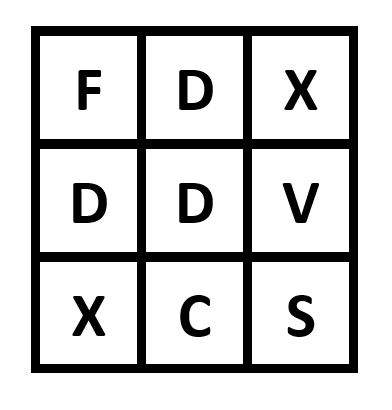

3 3
dimensione matrice 3x3

correzione immagine originale


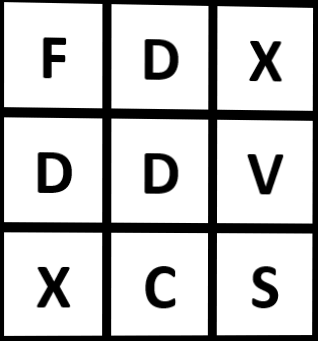

pulita


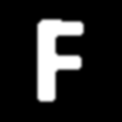

pulita


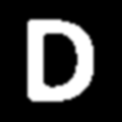

pulita


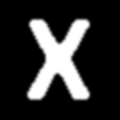

pulita


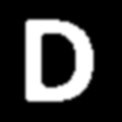

pulita


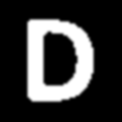

pulita


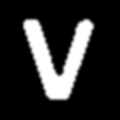

pulita


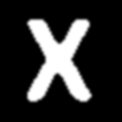

pulita


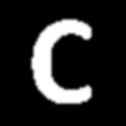

pulita


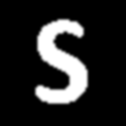

quadrati:  9


In [405]:
image = cv2.imread("/home/foto/prova12.png", cv2.IMREAD_GRAYSCALE)
image, n, m, h, w = trovaMatrice(image)
quadrati = trovaQuadrati(image, n, m, h, w)

In [406]:
#CARICAMENTO O CREAZIONE DEL MODELLO
from tensorflow.keras.models import load_model
if os.path.isfile('/home/modello/modello.h5'):
  model = load_model('/home/modello/modello.h5')
else:
  model = creaModello()
model.summary()

(124800, 28, 28)
(124800,)
Epoch 1/15
1317/1317 [==============================] - 12s 9ms/step - loss: 1.1895 - accuracy: 0.6744 - val_loss: 0.2609 - val_accuracy: 0.9108
Epoch 2/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.3164 - accuracy: 0.8981 - val_loss: 0.2008 - val_accuracy: 0.9309
Epoch 3/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.2613 - accuracy: 0.9130 - val_loss: 0.1877 - val_accuracy: 0.9355
Epoch 4/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.2340 - accuracy: 0.9246 - val_loss: 0.1869 - val_accuracy: 0.9342
Epoch 5/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.2177 - accuracy: 0.9269 - val_loss: 0.1703 - val_accuracy: 0.9385
Epoch 6/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.1938 - accuracy: 0.9347 - val_loss: 0.1614 - val_accuracy: 0.9392
Epoch 7/15
1317/1317 [==============================] - 11s 8ms/step - loss: 0.1887 - accuracy: 0.9361 

In [407]:
from os import system
from search import *
from utils import *
import sys
from collections import deque
import heapq
class SmartVacuum(Problem):
  def __init(self, initial, goal):
    super().__init__(initial, goal)
  
  def actions(self, state): #ritorna le azioni possibili in un determinato stato
    room, pos_x, pos_y = state
    possible_actions = ['CLEAN', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    if room[pos_x][pos_y] == 'c' or room[pos_x][pos_y] == 'f' or room[pos_x][pos_y] == 's':
      possible_actions.remove('CLEAN')    
    if pos_y == 0:
      possible_actions.remove('LEFT')
    else:
      if room[pos_x][pos_y-1] == 'x':
        possible_actions.remove('LEFT')
    if pos_y == len(self.goal[0][0])-1:
      possible_actions.remove('RIGHT')
    else:
      if room[pos_x][pos_y+1] == 'x':
        possible_actions.remove('RIGHT')
    if pos_x == 0:
      possible_actions.remove('UP')
    else:
      if room[pos_x-1][pos_y] == 'x':
        possible_actions.remove('UP')
    if pos_x == len(self.goal[0][0])-1:
      possible_actions.remove('DOWN')
    else:
      if room[pos_x+1][pos_y] == 'x':
        possible_actions.remove('DOWN')
    
    
    return possible_actions
  
  def result(self,state, action):
    room, pos_x, pos_y = state
    righe = len(room)
    colonne = len(room[0])
    new_room = []
    for i in range(righe):
      row = []
      for j in range(colonne):
        row.append(room[i][j])
      new_room.append(row)
    new_state = []
    new_state.append(new_room)
    new_state.append(pos_x)
    new_state.append(pos_y)
    r, x, y = new_state
    if action == 'LEFT':
      #print("LEFT ", pos_x, pos_y, room[pos_x][pos_y])
      y -=1
    elif action == 'RIGHT':
      #print("RIGHT ", pos_x, pos_y, room[pos_x][pos_y])
      y +=1
    elif action == 'UP':
      #print("UP ", pos_x, pos_y, room[pos_x][pos_y])
      x -=1
    elif action == 'DOWN':
      #print("DOWN ", pos_x, pos_y, room[pos_x][pos_y])
      x +=1
    elif action == 'CLEAN':
      #print("CLEAN ", pos_x, pos_y, room[pos_x][pos_y])
      if(r[x][y] == 'v'):
        r[x][y] = 'd'
      elif(r[x][y] == 'd'):
        r[x][y] = 'c'
    new_state = [r, x, y]
    return new_state

  def goal_test(self, state):
    room, pos_x, pos_y = state
    room_goal, pos_x_goal, pos_y_goal = self.goal
    if(room == room_goal and pos_x == pos_x_goal and pos_y == pos_y_goal):
      #print("goal: ", self.goal)
      return True
    else:
      return False
  
  def h(self, node):
    return 0

def path_to_node(node): #RITORNA IL PERCORSO ESEGUITO DAL NODO DA START A FINISH(IL CAMMINO DELLA SOLUZIONE)
    h = []
    p = node
    while p is not None:
        h.append(p.state)
        p = p.parent
    h.reverse()
    conta=0
    for n in h:
      r, x, y = n
      print("stato:", n, ", lettera: ", r[x][y])
      conta +=1
    print("azioni: ", conta)
    return h , conta

In [408]:
def bfs(problem):
    frontier = deque([Node(problem.initial)])  # FIFO queue

    while frontier:
        node =frontier.popleft()
        r, x, y = node.state
        #print("stato corrente: ", node.state, ", lettera: ", r[x][y])
        if problem.goal_test(node.state):
            return node
        frontier.extend(node.expand(problem))
    return None

numero quadrati:  9
dimensione matrice:  3 x 3


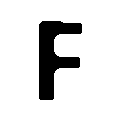

label:  f


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


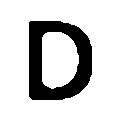

label:  d


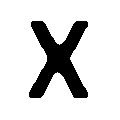

label:  x


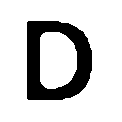

label:  d


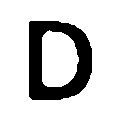

label:  d


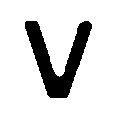

label:  v


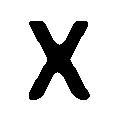

label:  x


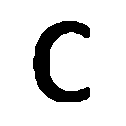

label:  c


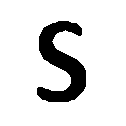

label:  s
stato iniziale:  ([['f', 'd', 'x'], ['d', 'd', 'v'], ['x', 'c', 's']], 2, 2)
stato goal:  ([['f', 'c', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 0)


In [409]:
ini, goa = previsioni(n, m, quadrati, model)
print("stato iniziale: ", ini)
print("stato goal: ", goa)

In [410]:
#definizione euristiche e varie metodologie utilizzate, e ALGORITMI DI RICERCA
def max_dist_from_dirty(node):
  r, x, y = node.state
  d = 0
  righe = len(r)
  colonne = len(r[0])
  for i in range(righe):
    for j in range(colonne):
      if(r[i][j] == 'v' or r[i][j] == 'd'):
        if((abs(i-x)+abs(j-y))>d):
          d = (abs(i-x)+abs(j-y))
  return d

def min_dist_from_dirty(node):
  r, x, y = node.state
  righe = len(r)
  colonne = len(r[0])
  d = righe * colonne
  for i in range(righe):
    for j in range(colonne):
      if(r[i][j] == 'v' or r[i][j] == 'd'):
        if((abs(i-x)+abs(j-y))<d):
          d = (abs(i-x)+abs(j-y))
  return d

def max_dist_from_f_X_control(node):
  r, x, y = node.state
  d = 0
  righe = len(r)
  colonne = len(r[0])
  for i in range(righe):
    for j in range(colonne):
      if(r[i][j] == 'f'):
        xf, yf = i, j
        d = (abs(i-x)+abs(j-y))
  if(xf<x):   #F in alto
    if(yf<y): #F in alto a sinistra
      for i in range(xf,x+1):
        for j in range(yf,y+1):
          if(r[i][j] == 'x'):
            d += 2
    elif(yf>y): #F in alto a destra
      for i in range(xf,x+1):
        for j in range(y,yf+1):
          if(r[i][j] == 'x'):
            d += 2
    elif(yf==y): #F sulla stessa colonna
      for i in range(xf,x+1):
        if(r[i][j] == 'x'):
          d += 2
  elif(xf>x): #F in basso
    if(yf<y): #F in basso a sinistra
      for i in range(x,xf+1):
        for j in range(yf,y+1):
          if(r[i][j] == 'x'):
            d += 2
    elif(yf>y): #F in basso a destra
      for i in range(x,xf+1):
        for j in range(y,yf+1):
          if(r[i][j] == 'x'):
            d += 2
    elif(yf==y): #F sulla stessa colonna
      for i in range(x,xf+1):
        if(r[i][j] == 'x'):
            d += 2
  elif(xf==x): #F sulla stessa riga
    if(yf<y): #F a sinistra
      for i in range(yf,y+1):
        if(r[i][j] == 'x'):
          d += 2
    elif(yf>y): #F a destra
      for i in range(y,yf+1):
        if(r[i][j] == 'x'):
          d += 2
  return d

def max_dist_from_f(node):
  r, x, y = node.state
  d = 0
  righe = len(r)
  colonne = len(r[0])
  for i in range(righe):
    for j in range(colonne):
      if(r[i][j] == 'f'):
        xf, yf = i, j
        d = (abs(i-x)+abs(j-y))

  return d

def cleaning_operations(node):
  r, x, y = node.state
  c = 0
  righe = len(r)
  colonne = len(r[0])
  contax=0
  for i in range(righe):
    for j in range(colonne):
      if(r[i][j] == 'd'):
        c += 1
      if(r[i][j] == 'v'):
        c += 2

  return c

def heuristicA(node):
  d1 = min_dist_from_dirty(node)
  d2 = max_dist_from_f_X_control(node)
  c = cleaning_operations(node)
  c *= 3
  d1 /= 4
  d2 /= 3
  return c+d1+d2

def heuristicB(node):
  d2 = max_dist_from_f_X_control(node)
  c = cleaning_operations(node)
  c *= 3
  d2 /= 3
  return c+d2

def heuristicC(node):
  d2 = max_dist_from_f(node)
  c = cleaning_operations(node)
  c *= 3
  d2 /= 3
  return c+d2

def heuristicD(node):
  d2 = max_dist_from_f(node)
  c = cleaning_operations(node)
  return c+d2

def best_first(problem, f, display=False):
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = []
    while frontier:
        node = frontier.pop()
        r, x, y = node.state
        #print("Nodo corrente: ", node.state, ", lettera: ", r[x][y])
        if problem.goal_test(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            return node
        explored.append(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None

def astar(problem, h=None, display=False):
    h = memoize(h or problem.h, 'h')
    return best_first(problem, lambda n: n.path_cost + h(n), display)

In [411]:
#RICERCA NON INFORMATA
if(n < 4):
  result = bfs(SmartVacuum(ini, goa))
  cammino, azioni =  path_to_node(result)
  print("path:" , cammino)

stato: ([['f', 'd', 'x'], ['d', 'd', 'v'], ['x', 'c', 's']], 2, 2) , lettera:  s
stato: [[['f', 'd', 'x'], ['d', 'd', 'v'], ['x', 'c', 's']], 1, 2] , lettera:  v
stato: [[['f', 'd', 'x'], ['d', 'd', 'd'], ['x', 'c', 's']], 1, 2] , lettera:  d
stato: [[['f', 'd', 'x'], ['d', 'd', 'c'], ['x', 'c', 's']], 1, 2] , lettera:  c
stato: [[['f', 'd', 'x'], ['d', 'd', 'c'], ['x', 'c', 's']], 1, 1] , lettera:  d
stato: [[['f', 'd', 'x'], ['d', 'c', 'c'], ['x', 'c', 's']], 1, 1] , lettera:  c
stato: [[['f', 'd', 'x'], ['d', 'c', 'c'], ['x', 'c', 's']], 1, 0] , lettera:  d
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 1, 0] , lettera:  c
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 1, 1] , lettera:  c
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 1] , lettera:  d
stato: [[['f', 'c', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 1] , lettera:  c
stato: [[['f', 'c', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 0] , lettera:  f
azioni:  12
path: [([['f', '

In [412]:
#RICERCA INFORMATA
result = 0
#in base alla dimensione si esegue un'euristica diversa in modo da trovare un cammino migliore
if(n > 2 and n < 6): 
  result = astar(SmartVacuum(ini, goa), h = heuristicA)
elif(n > 5 and n < 7):
  result = astar(SmartVacuum(ini, goa), h = heuristicB)
elif(n > 6 and n < 8):
  result = astar(SmartVacuum(ini, goa), h = heuristicC)

if(result != 0):
  
  cammino, azioni = path_to_node(result)

stato: ([['f', 'd', 'x'], ['d', 'd', 'v'], ['x', 'c', 's']], 2, 2) , lettera:  s
stato: [[['f', 'd', 'x'], ['d', 'd', 'v'], ['x', 'c', 's']], 1, 2] , lettera:  v
stato: [[['f', 'd', 'x'], ['d', 'd', 'd'], ['x', 'c', 's']], 1, 2] , lettera:  d
stato: [[['f', 'd', 'x'], ['d', 'd', 'c'], ['x', 'c', 's']], 1, 2] , lettera:  c
stato: [[['f', 'd', 'x'], ['d', 'd', 'c'], ['x', 'c', 's']], 1, 1] , lettera:  d
stato: [[['f', 'd', 'x'], ['d', 'c', 'c'], ['x', 'c', 's']], 1, 1] , lettera:  c
stato: [[['f', 'd', 'x'], ['d', 'c', 'c'], ['x', 'c', 's']], 1, 0] , lettera:  d
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 1, 0] , lettera:  c
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 0] , lettera:  f
stato: [[['f', 'd', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 1] , lettera:  d
stato: [[['f', 'c', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 1] , lettera:  c
stato: [[['f', 'c', 'x'], ['c', 'c', 'c'], ['x', 'c', 's']], 0, 0] , lettera:  f
azioni:  12


In [413]:
r, x, y = cammino[0]
print(x, y)

2 2


In [414]:
pip install pygame

In [415]:
import pygame

In [416]:
def resizeSprite(dimensioneMat):
  dim = (600/dimensioneMat)-50
  dim = int(dim)
  filepath = ""
  for i in range(8): #ridimensiona movimento dx
    filepath = '/home/sprite/luigiMovimento/LM'+str(i)+'DX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(8): #ridimensiona movimento sx
    filepath = '/home/sprite/luigiMovimento/LM'+str(i)+'SX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(3): #ridimensiona clean dx
    filepath = '/home/sprite/luigiClean/LC'+str(i)+'DX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(3): #ridimensiona clean sx
    filepath = '/home/sprite/luigiClean/LC'+str(i)+'SX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(4): #ridimensiona start dx
    filepath = '/home/sprite/luigiStart/LS'+str(i)+'DX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(4): #ridimensiona start sx
    filepath = '/home/sprite/luigiStart/LS'+str(i)+'SX.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  for i in range(2): #ridimensiona start sx
    filepath = '/home/sprite/luigiFinale/LF'+str(i)+'.png'
    image = cv2.imread(filepath)
    image = cv2.resize(image, (dim,dim))
    cv2.imwrite(filepath, image)
  
  filepath = "/home/sprite/altri/divieto.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)
  filepath = "/home/sprite/altri/pulito.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)
  filepath = "/home/sprite/altri/sporco.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)
  filepath = "/home/sprite/altri/veramenteSporco.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)
  filepath = "/home/sprite/altri/start.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)
  filepath = "/home/sprite/altri/finish.png"
  image = cv2.imread(filepath)
  image = cv2.resize(image, (dim,dim))
  cv2.imwrite(filepath, image)

  return dim+30

def spawnSprite(filepath, player):
  player.surf = pygame.image.load(filepath).convert()
  player.surf.set_colorkey((255, 255, 255), RLEACCEL)
  player.rect = player.surf.get_rect()
  return player

def spawn(cammino, dimensioneMat, dimensioneSprite):
  room, y, x = cammino[0]
  cx = ((600/(dimensioneMat))*(x+1))-dimensioneSprite
  cy = ((600/(dimensioneMat))*(y+1))-dimensioneSprite
  filepath = "" #sprite girato nella direzione corretta
  if(x <= int(dimensioneMat/2)):
      filepath = '/home/sprite/luigiStart/LS0DX.png'
  else:
      filepath = '/home/sprite/luigiStart/LS0SX.png'

  return cx, cy , filepath

def animazioneIniziale(conta, filepath):
  if conta < 3 :
    if(conta==1):
      filepath = filepath.replace('0', '1')
    if(conta==2):
      filepath = filepath.replace('1', '2')
  return filepath

def mappaSfondo(dimensione):
  image = cv2.imread('/home/spriteStanza/'+ str(dimensione)+'x'+str(dimensione)+'.png')
  image = cv2.resize(image, (600,600))
  cv2.imwrite('/home/spriteStanza/'+ str(dimensione)+'x'+str(dimensione)+'.png', image)
  filepath = ('/home/spriteStanza/'+ str(dimensione)+'x'+str(dimensione)+'.png')
  return filepath

def spawnSporco(cammino, dimensioneMat, dimensioneSprite, i):
  filepath = ""
  r = cammino[i]
  righe = len(r)
  colonne = len(r[0])
  room = r[0]
  #print(righe, colonne)
  for a in range(len(r[0])):
    for b in range(len(r[0])):
      #print(a, b)
      if(room[b][a] == 'c'):
        filepath = "/home/sprite/altri/pulito.png"
      if(room[b][a] == 'x'):
        filepath = "/home/sprite/altri/divieto.png"
      if(room[b][a] == 'd'):
        filepath = "/home/sprite/altri/sporco.png"
      if(room[b][a] == 'v'):
        filepath = "/home/sprite/altri/veramenteSporco.png"
      if(room[b][a] == 's'):
        filepath = "/home/sprite/altri/start.png"
      if(room[b][a] == 'f'):
        filepath = "/home/sprite/altri/finish.png"
      s = Player(filepath)
      #s = spawnSprite(filepath, s)
      x = int(((600/(dimensioneMat))*(a+1))-dimensioneSprite)
      y = int(((600/(dimensioneMat))*(b+1))-dimensioneSprite)
      screen.blit(s.surf, (x, y))
      #print("stampa")
      #print(a, b, "ok")

def animazioneClean(x, y, cammino, dimensioneMat, dimensioneSprite, i,movementVariable, direzione):
  filepath = ""
  for indice in range(3):
    filepath = "/home/sprite/luigiClean/LC"+str(indice)+"DX.png"
    if(direzione):
      filepath = filepath.replace('DX', 'SX')  
    player.surf = pygame.image.load(filepath).convert()
    player.surf.set_colorkey((255, 255, 255), RLEACCEL)
    player.rect = player.surf.get_rect() #cambio sprite per simulare il movimento
    screen.fill((0,0,0))
    screen.blit(sfondo.surf, (0,0))
    spawnSporco(cammino, dimensioneMat, dimensioneSprite, i-1)
    screen.blit(player.surf, (x, y))
    pygame.display.flip()
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(0.5)

  screen.fill((0,0,0))
  screen.blit(sfondo.surf, (0,0))
  spawnSporco(cammino, dimensioneMat, dimensioneSprite, i)
  screen.blit(player.surf, (x, y))
  pygame.display.flip()
  view = pygame.surfarray.array3d(screen)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  cv2_imshow(img_bgr)
  #print(x, y)
  time.sleep(0.5)
  #output.clear()

def animazioneFinale(cammino, i, dimensioneMat, dimensioneSprite):
    r2, y2, x2 = cammino[i]
    cx2 = int(((600/(dimensioneMat))*(x2+1))-dimensioneSprite)
    cy2 = int(((600/(dimensioneMat))*(y2+1))-dimensioneSprite)
    filepath = ""
    for indice in range(2):
      filepath = "/home/sprite/luigiFinale/LF"+str(indice)+".png"
      player.surf = pygame.image.load(filepath).convert()
      player.surf.set_colorkey((255, 255, 255), RLEACCEL)
      player.rect = player.surf.get_rect() #cambio sprite per simulare il movimento
      screen.fill((0,0,0))
      screen.blit(sfondo.surf, (0,0))
      spawnSporco(cammino, dimensioneMat, dimensioneSprite, i-1)
      screen.blit(player.surf, (cx2, cy2))
      pygame.display.flip()
      view = pygame.surfarray.array3d(screen)
      view = view.transpose([1, 0, 2])
      img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
      cv2_imshow(img_bgr)
      time.sleep(0.5)

In [417]:
def stampa(x, y, cammino, dimensioneMat, dimensioneSprite, i,movementVariable, direzione):
  filepath = "/home/sprite/luigiMovimento/LM"+str(movementVariable)+"DX.png"
  if(direzione):
    filepath = filepath.replace('DX', 'SX')  
  player.surf = pygame.image.load(filepath).convert()
  player.surf.set_colorkey((255, 255, 255), RLEACCEL)
  player.rect = player.surf.get_rect() #cambio sprite per simulare il movimento
  screen.fill((0,0,0))
  screen.blit(sfondo.surf, (0,0))
  spawnSporco(cammino, dimensioneMat, dimensioneSprite, i)
  screen.blit(player.surf, (x, y))
  pygame.display.flip()
  view = pygame.surfarray.array3d(screen)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  cv2_imshow(img_bgr)
  #print(x, y)
  time.sleep(0.5)
  #output.clear()

def movimento(cammino, dimensioneMat, dimensioneSprite, i):
  sinistra = False #variabile che indica se lo spostamento è verso sinistra
  movementVariable = 0
  r1, y1, x1 = cammino[i-1]
  r2, y2, x2 = cammino[i]
  cx1 = int(((600/(dimensioneMat))*(x1+1))-dimensioneSprite)
  cy1 = int(((600/(dimensioneMat))*(y1+1))-dimensioneSprite)
  cx2 = int(((600/(dimensioneMat))*(x2+1))-dimensioneSprite)
  cy2 = int(((600/(dimensioneMat))*(y2+1))-dimensioneSprite)
  #print(cx1, cy1, cx2, cy2)
  if(cx1!=cx2):
    if(cy1!=cy2): #coordinate tutte diverse
      ez = 0
      #spostamento in entrambi gli assi (SITUAZIONE IMPOSSIBILE)
    else: #cy1=cy2
      #print("spostamento nell'asse x")
      if(cx1<cx2):
        for a in range(cx1, cx2+1, 10): #spostamento a destra
          sinistra = False
          stampa(a, cy2, cammino, dimensioneMat, dimensioneSprite, i, movementVariable, sinistra)
          if(movementVariable == 7):
            movementVariable = 0
          movementVariable +=1
      else:
        for a in range(cx1, cx2-1, -10): #spostamento a sinistra
          sinistra = True
          stampa(a, cy2, cammino, dimensioneMat, dimensioneSprite, i, movementVariable, sinistra)
          if(movementVariable == 7):
            movementVariable = 0
          movementVariable +=1
  else: #cx1=cx2
    if(cy1!=cy2):
      #print("spostamento nell'asse y")
      if(cy1<cy2):
        for b in range(cy1, cy2+1, 10):
          stampa(cx2, b, cammino, dimensioneMat, dimensioneSprite, i, movementVariable, sinistra)
          if(movementVariable == 7):
            movementVariable = 0
          movementVariable +=1
      else:
        for b in range(cy1, cy2-1, -10):
          stampa(cx2, b, cammino, dimensioneMat, dimensioneSprite, i, movementVariable, sinistra)
          if(movementVariable == 7):
            movementVariable = 0
          movementVariable +=1
    else:
      animazioneClean(cx2, cy2, cammino, dimensioneMat, dimensioneSprite, i, movementVariable, sinistra)


In [418]:
class Player(pygame.sprite.Sprite):
    def __init__(self, filepath):
        super(Player, self).__init__()
        self.surf = pygame.image.load(filepath).convert()
        self.surf.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.surf.get_rect()


# Define the cloud object by extending pygame.sprite.Sprite
# Use an image for a better-looking sprite
class Sfondo(pygame.sprite.Sprite):
    def __init__(self, filepath):
        super(Sfondo, self).__init__()
        self.surf = pygame.image.load(filepath).convert()
        self.surf.set_colorkey((0, 0, 0), RLEACCEL)
        # The starting position is randomly generated
        self.rect = self.surf.get_rect()

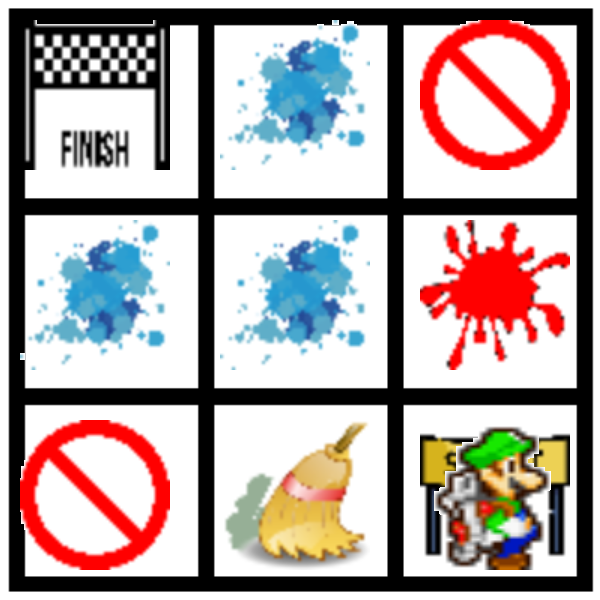

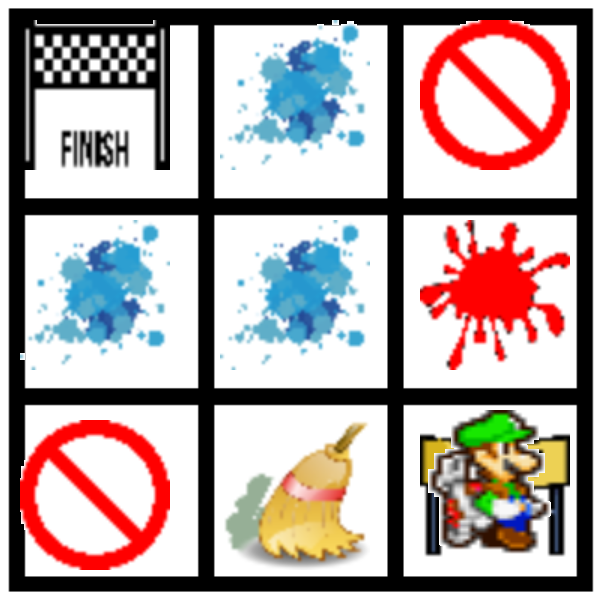

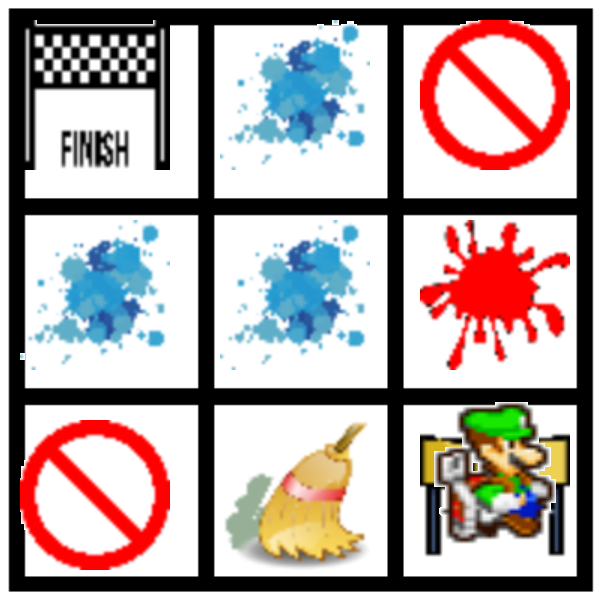

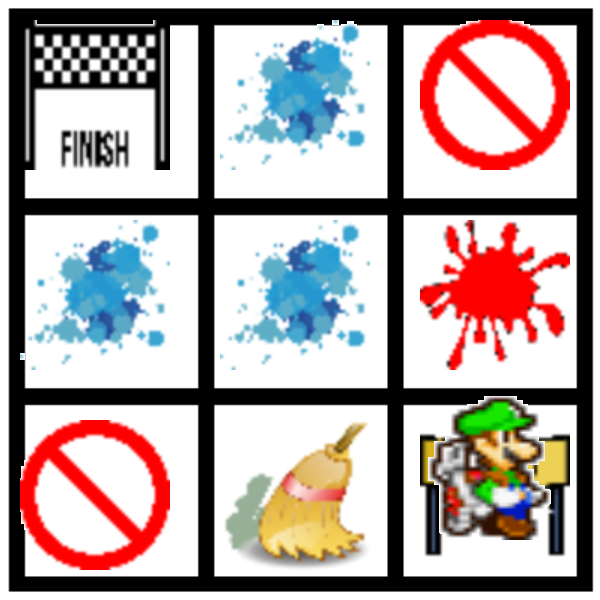

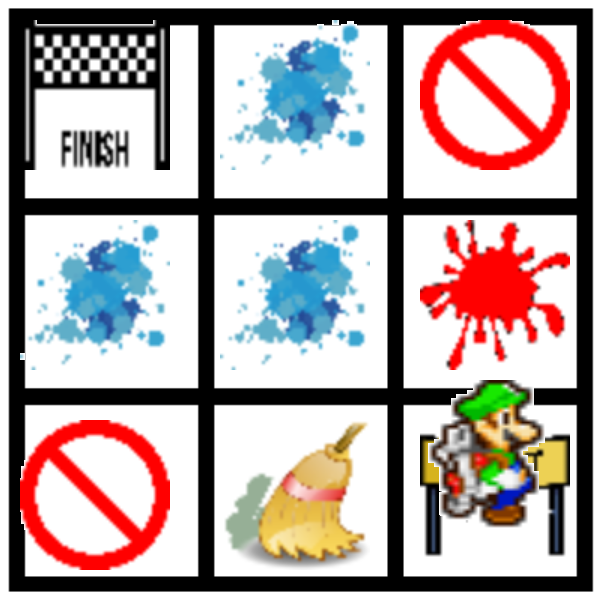

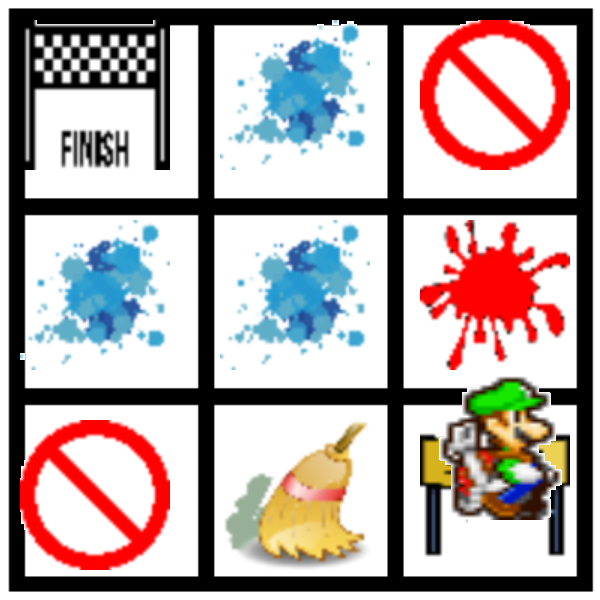

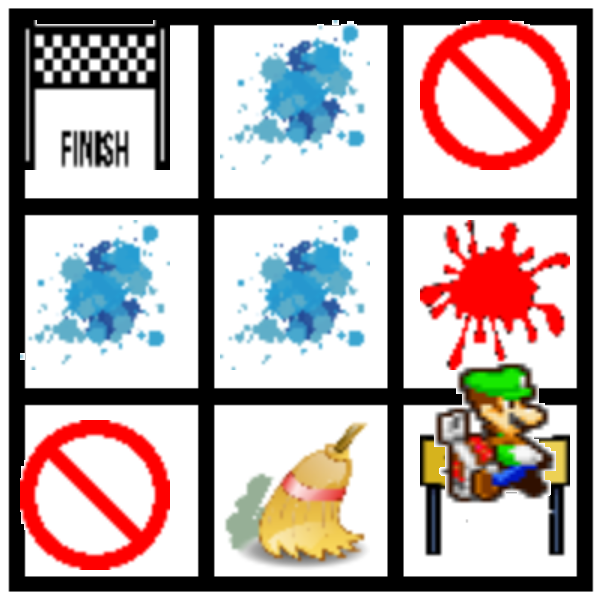

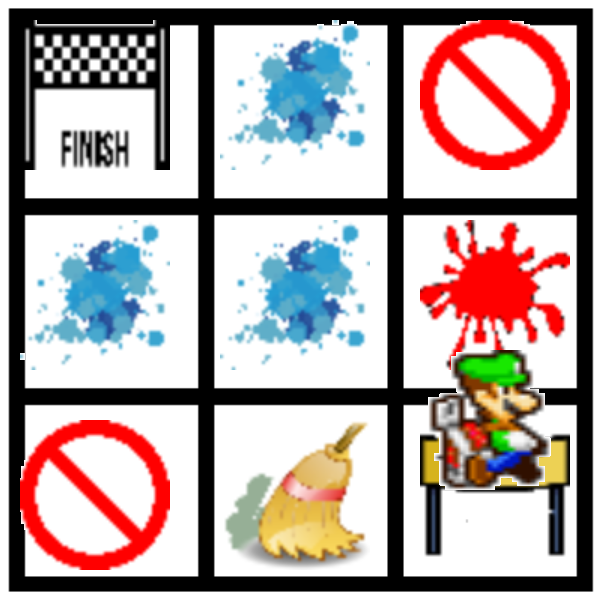

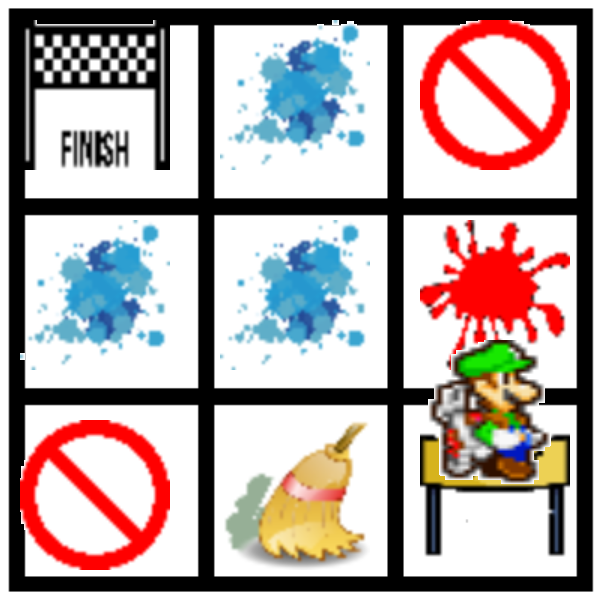

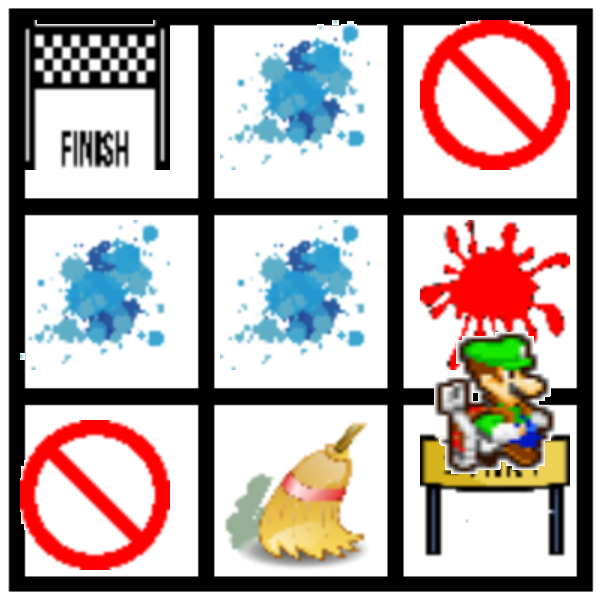

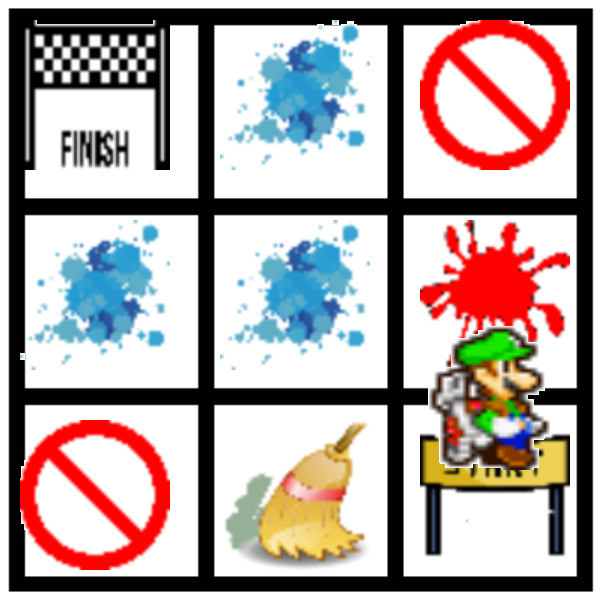

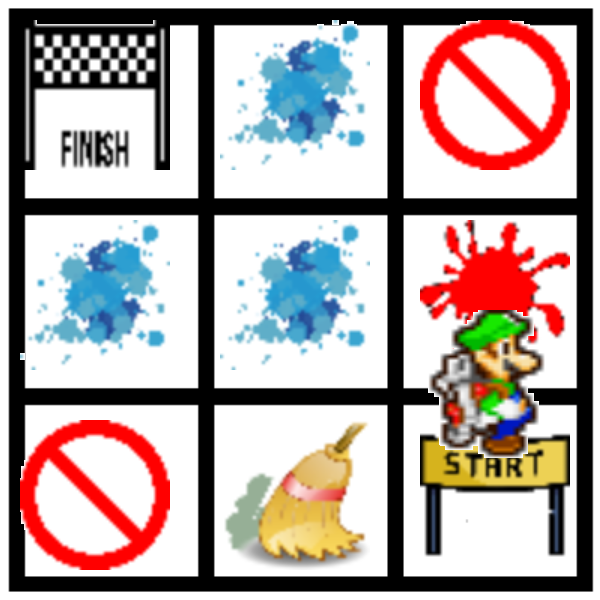

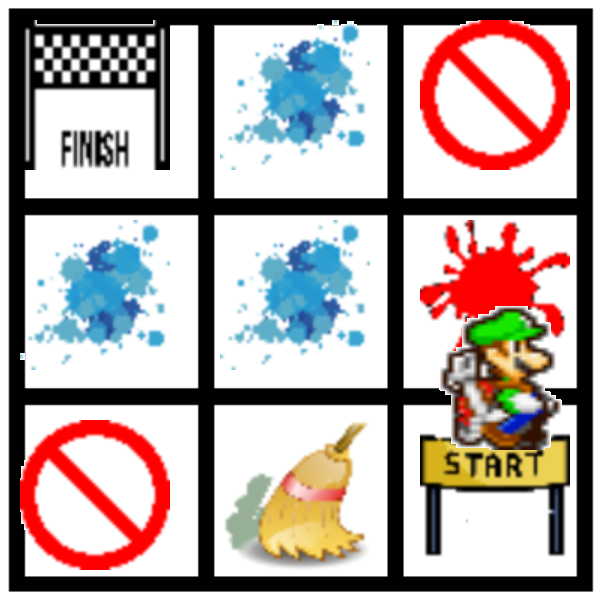

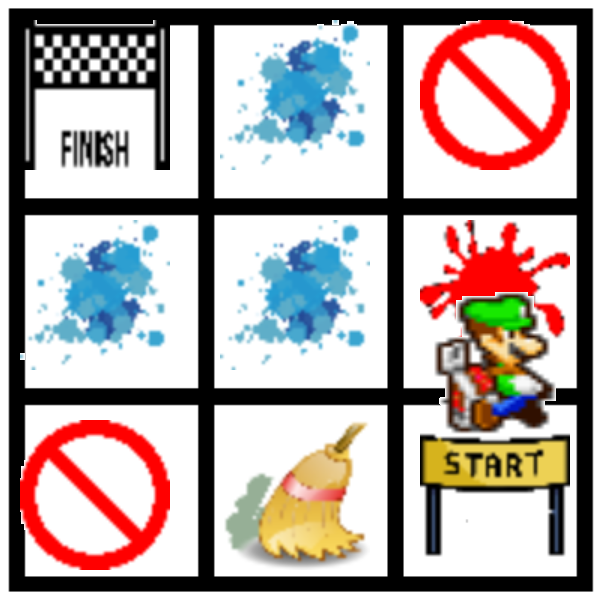

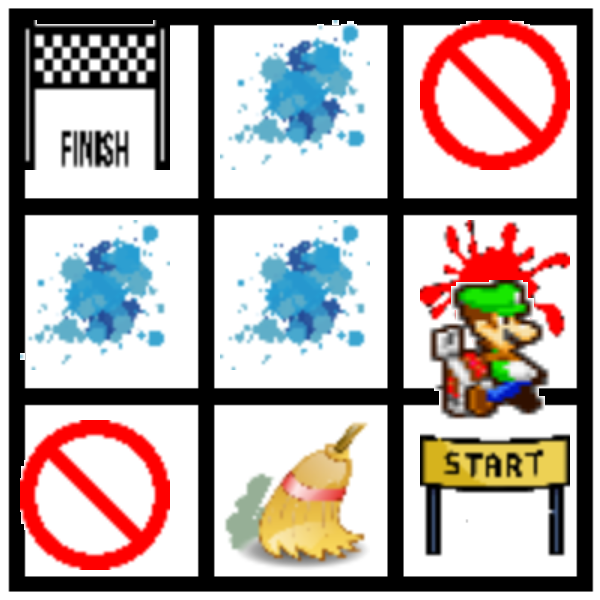

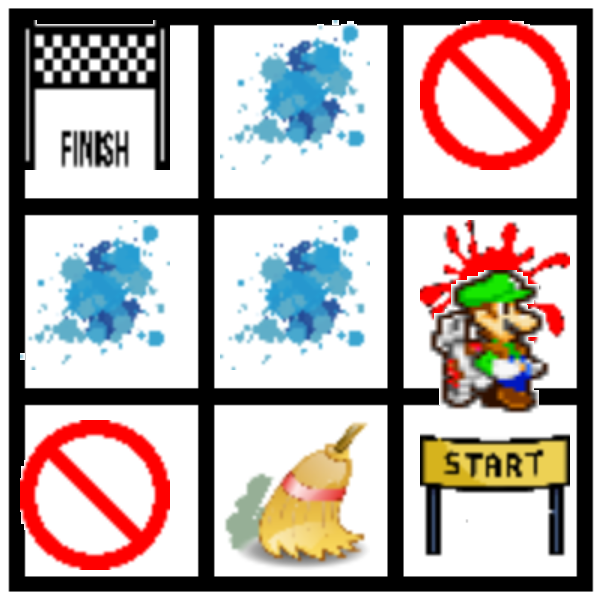

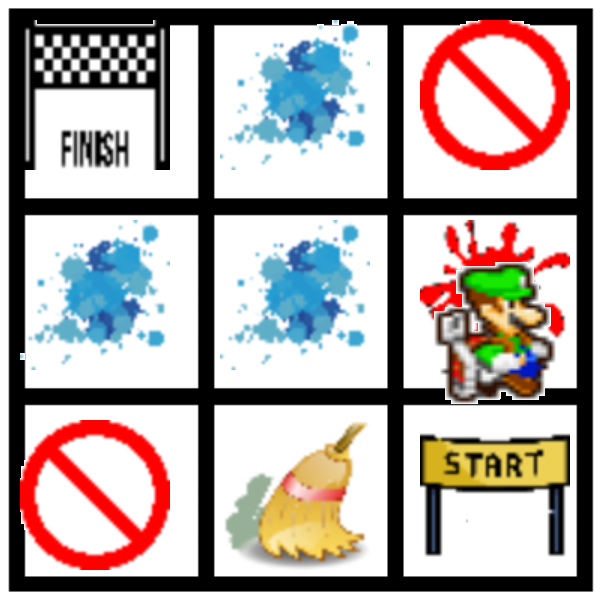

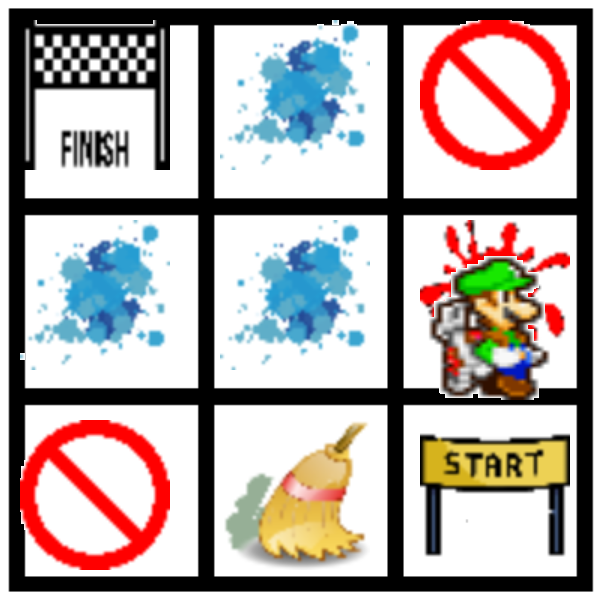

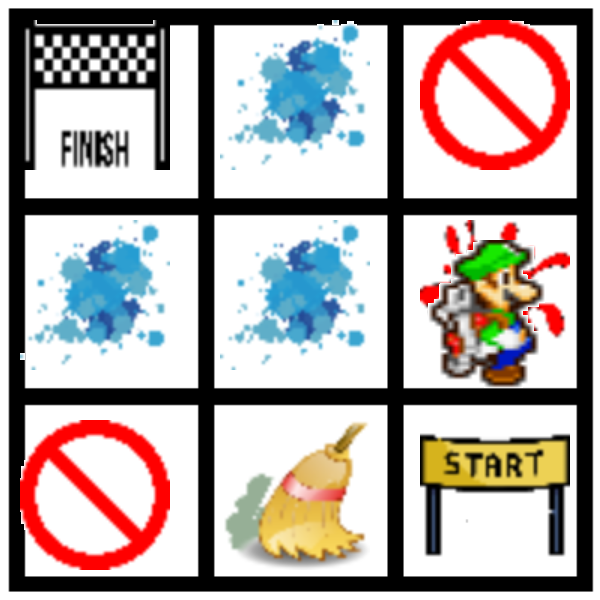

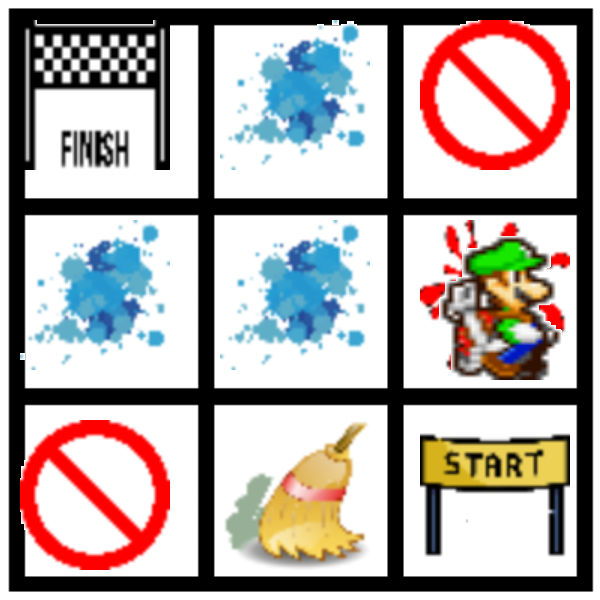

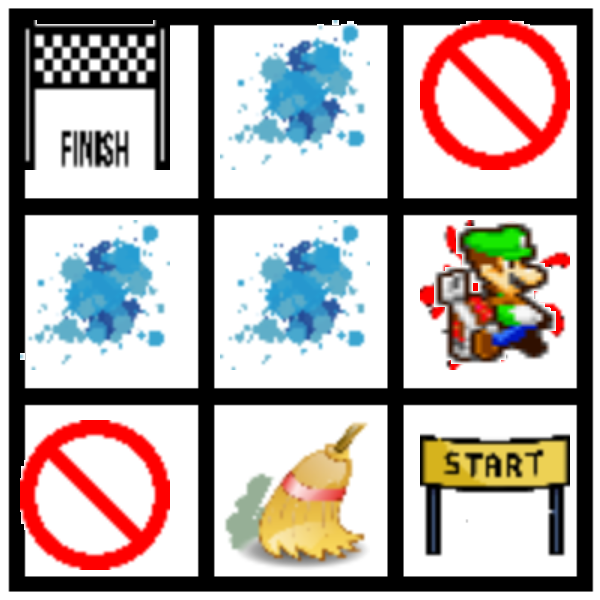

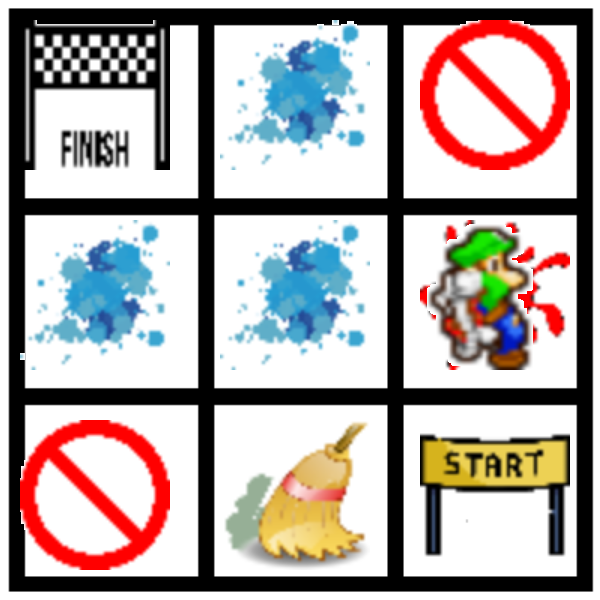

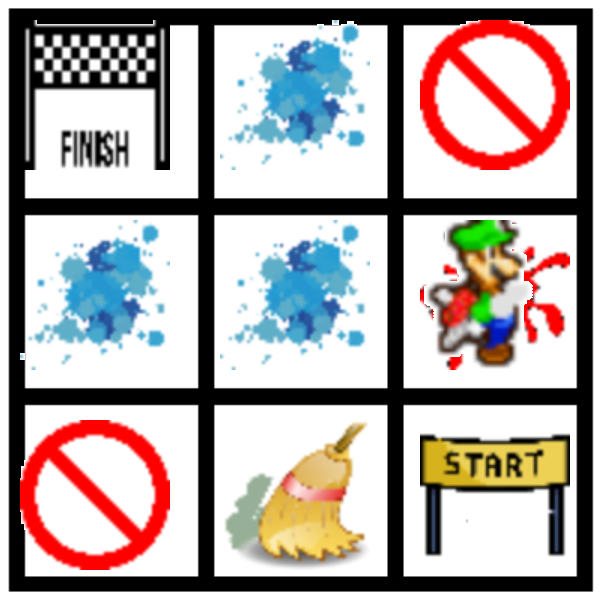

KeyboardInterrupt: ignored

In [419]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"


from pygame.locals import (
    RLEACCEL,
    K_UP,
    K_DOWN,
    K_LEFT,
    K_RIGHT,
    K_ESCAPE,
    KEYDOWN,
    QUIT,
)

pygame.init()
mappa = mappaSfondo(n) #assegna la matrice ridimensionata per metterla come sfondo
image = cv2.imread(mappa)
dim = resizeSprite(n) #ridimensiona lo sprite in base alla dimensione della cella

screen = pygame.display.set_mode((image.shape[1], image.shape[0])) #imposta le dimensioni dello schermo grandi quanto la maooa
done = False
is_blue = True
x, y , sprite = spawn(cammino, n, dim)

player = Player(sprite) #assegna lo sprite al giocatore

sfondo = Sfondo(mappa) #imposta la matrice come sfondo

conta = 0
i=1
immagine = sprite
while not done:
        for event in pygame.event.get():
          if event.type == pygame.QUIT:
            done = True
        
        if(conta<4):
          screen.fill((0, 0, 0))
          immagine = animazioneIniziale(conta, immagine)
          # Draw the player on the screen
          screen.blit(sfondo.surf, (0,0))
          spawnSporco(cammino, n, dim, 0)
          player = spawnSprite(immagine, player)
          screen.blit(player.surf, (x, y))
          conta = conta+1
          # Update the display
          pygame.display.flip()
          #convert image so it can be displayed in OpenCV
          view = pygame.surfarray.array3d(screen)
          #  convert from (width, height, channel) to (height, width, channel)
          view = view.transpose([1, 0, 2])
          #  convert from rgb to bgr
          img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
          #Display image, clear cell every 0.5 seconds
          cv2_imshow(img_bgr)
          time.sleep(0.5)
          output.clear()
        else:
          if(i < azioni):
            #print("movimento ", i)
            movimento(cammino, n, dim, i)
            i += 1
          else:
           animazioneFinale(cammino,i-1, n, dim)
           #done = True #togliere il commento per farlo stoppare alla fine

